<a href="https://colab.research.google.com/github/REYES-AFMR/BEELEC1-EG1_Group2/blob/main/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing relevant libraries

# manipulate files online, interact with the operating system
import os
# numpy for numerical operations like arryas and metrices
import numpy as np
# Importing the 'cv2' (OpenCV) library for computer vision tasks like image processing
import cv2
# Importing the train_test_split function to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Importing 'matplotlib.pyplot' for creating visualizations like plots and charts
import matplotlib.pyplot as plt

from types import NoneType

# Import the to_categorical function from tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical

In [ ]:
# LOADING IMAGES:
from google.colab import drive
drive.mount('/content/drive')
datasetPath = '/content/drive/Shared drives/BEELEC1/Dataset'

# getting MRI images
pathMRI = os.path.join(datasetPath, "Brain Tumor MRI images")
pathTumorMRI = os.path.join(pathMRI, "Tumor")
pathHealthyMRI = os.path.join(pathMRI, "Healthy")

# getting CT scan images
pathCT = os.path.join(datasetPath, "Brain Tumor CT scan Images")
pathTumorCT = os.path.join(pathCT, "Tumor")
pathHealthyCT = os.path.join(pathCT, "Healthy")

# loading into respective arrays: MRI
dataMRI = []
labelMRI = []

for i in os.listdir(pathTumorMRI):
  tempImg = cv2.imread(os.path.join(pathTumorMRI, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (224, 224)) # resizing for uniformity
    dataMRI.append(resizedImg)
    labelMRI.append(1)
  else:
    continue

for i in os.listdir(pathHealthyMRI):
  tempImg = cv2.imread(os.path.join(pathHealthyMRI, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (224, 224))
    dataMRI.append(resizedImg)
    labelMRI.append(0)
  else:
    continue

# loading into respective arrays: CT Scan
dataCT = []
labelCT = []

for i in os.listdir(pathTumorCT):
  tempImg = cv2.imread(os.path.join(pathTumorCT, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (224, 224))
    dataCT.append(resizedImg)
    labelCT.append(1)
  else:
    continue

for i in os.listdir(pathHealthyCT):
  tempImg = cv2.imread(os.path.join(pathHealthyCT, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (224, 224))
    dataCT.append(resizedImg)
    labelCT.append(0)
  else:
    continue


print("IMAGE SIZES:")
print(f"MRIs images = {np.array(dataMRI).shape}, MRI labels = {to_categorical(np.array(labelMRI)).shape}")
print(f"CT scans = {np.array(dataCT).shape}, CT labels = {to_categorical(np.array(labelCT)).shape}")

Mounted at /content/drive
IMAGE SIZES:
MRIs images = (5000, 224, 224, 3), MRI labels = (5000, 2)
CT scans = (4618, 224, 224, 3), CT labels = (4618, 2)


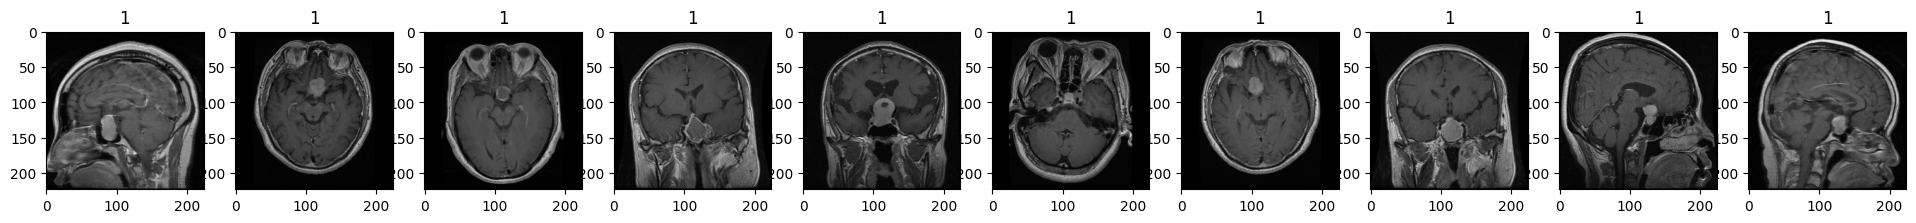

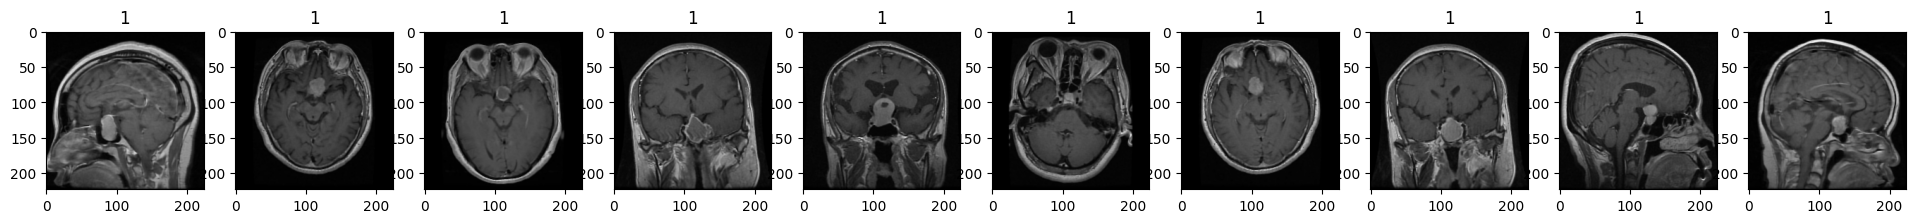

In [ ]:
# PREPROCESSING: MRI
# best method: unsharp masking + bilateral filter. SigmaX 3, alpha 1.5, filter size 9, sigmaColor 75 sigmaSpace 75
# grayscale -> unsharp masking process: gaussian blur, 1.5 weight OG image + -0.5 weight blurred image -> pass through bilaterial filter

# unsharp masking process can be used using cv2's addWeighted() function

def MRI_preprocessing(MRI_img):
  # convert to grayscale values
  imgGS = cv2.cvtColor(MRI_img, cv2.COLOR_BGR2GRAY)
  # denoise with gaussian blur with size 9 (3x3)
  imgGB = cv2.GaussianBlur(imgGS, (3,3), 0)
  # add the weighted images for unsharp masking with alpha 1.5, beta -0.5
  imgUM = cv2.addWeighted(imgGS, 1.5, imgGB, -0.5, 0)
  # pass result into a bilateral filter with sigmaX 3, sigmaColor 75, and sigmaSpace 75
  imgBF = cv2.bilateralFilter(imgUM, 3, 75, 75)
  # Grayscale to RGB again since MobileNetV2 only works with RGB
  imgRGB = cv2.cvtColor(imgBF, cv2.COLOR_GRAY2RGB)
  return imgRGB.astype(np.float32) / 255.0

dataMRIpro = []

for i in dataMRI:
  dataMRIpro.append(MRI_preprocessing(i))

# showing results
size = 10

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display original image
    ax[i].imshow(dataMRI[i], cmap='binary')
    ax[i].set_title(labelMRI[i])

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display processed
    ax[i].imshow(dataMRIpro[i], cmap='binary')
    ax[i].set_title(labelMRI[i])

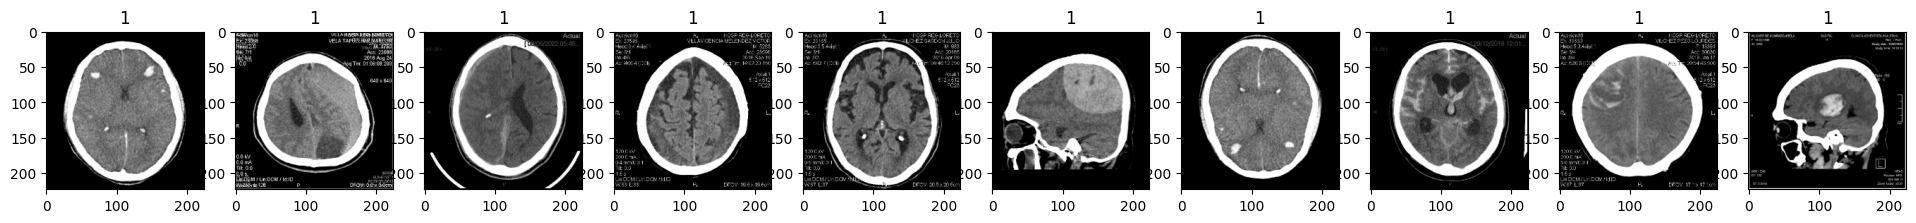

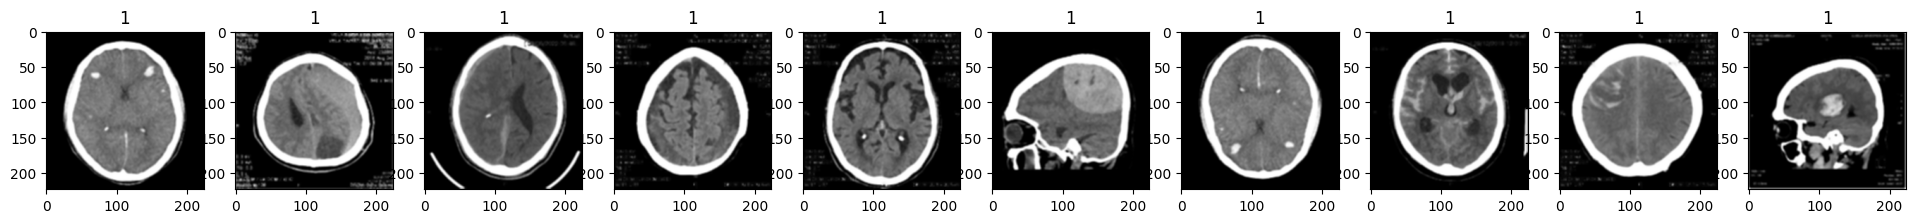

In [ ]:
# PREPROCESSING: CT
# best method: median-mean hybrid filter. window size 3x3
# grayscale -> pass through median filter -> pass through mean filter
# while usually done for median filters, padding is unnecessary as medical images in use already have black borders

def CT_preprocessing(CT_img):
  # convert to grayscale values
  imgGS = cv2.cvtColor(CT_img, cv2.COLOR_BGR2GRAY)
  # median filter kernel size 3 (3x3 window)
  imgMed = cv2.medianBlur(imgGS, 3)
  # mean filter kernel shape 3x3
  imgMean = cv2.blur(imgMed, (3,3))
  # Grayscale to RGB again since MobileNetV2 only works with RGB
  imgRGB = cv2.cvtColor(imgMean, cv2.COLOR_GRAY2RGB)
  return imgRGB.astype(np.float32) / 255.0

dataCTpro = []

for i in dataCT:
  dataCTpro.append(CT_preprocessing(i))

# showing results
size = 10

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display original image
    ax[i].imshow(dataCT[i], cmap='binary')
    ax[i].set_title(labelCT[i])

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display masks
    ax[i].imshow(dataCTpro[i], cmap='binary')
    ax[i].set_title(labelCT[i])


In [ ]:
#Train-Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224,224)

# Train-Test for MRI
gendata_MRI = ImageDataGenerator(preprocessing_function=MRI_preprocessing, validation_split=0.2)
training_MRI = gendata_MRI.flow_from_directory(pathMRI, target_size=image_size, batch_size=16, class_mode='categorical', subset='training', shuffle=True)
test_MRI = gendata_MRI.flow_from_directory(pathMRI, target_size=image_size, batch_size=16, class_mode='categorical', subset='validation', shuffle=False)

# Train-Test for CT
gendata_CT = ImageDataGenerator(preprocessing_function=CT_preprocessing, validation_split=0.2)
training_CT = gendata_CT.flow_from_directory(pathCT, target_size=image_size, batch_size=16, class_mode='categorical', subset='training', shuffle=True)
test_CT = gendata_CT.flow_from_directory(pathCT, target_size=image_size, batch_size=16, class_mode='categorical', subset='validation', shuffle=False)

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 3695 images belonging to 2 classes.
Found 923 images belonging to 2 classes.


In [ ]:
import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.models import Sequential                 # Sequential model is a linear stack of layers where data flows from one layer to the next.
from keras.layers import Dense                      # Dense: A fully connected (FC) layer where each neuron is connected to all neurons in the previous layer.
from keras.layers import Dropout                    # Dropout: A regularization technique that randomly disables a fraction of neurons during training.

from keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **MOBILE NET**

In [ ]:
# Instantiate a Keras Sequential object
mobnet_model= Sequential()

# Add MobileNetV2 as the feature extractor
mobilenet_base = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

# Freeze the base model layers (to use pre-trained features)
mobilenet_base.trainable = False

mobnet_model.add(mobilenet_base)

# GlobalAveragePooling to reduce overfitting
mobnet_model.add(GlobalAveragePooling2D())

# Fully Connected Layers
mobnet_model.add(Dense(units=512, activation="relu"))
mobnet_model.add(Dropout(0.3))
mobnet_model.add(Dense(units=2, activation="softmax"))  # Output layer for 2 classes

# Display model summary
mobnet_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile the model
mobnet_model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Train the model for MRI
model_history_MRI = mobnet_model.fit(training_MRI,epochs=5, batch_size=100, shuffle=True, validation_data=test_MRI)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - categorical_accuracy: 0.9544 - loss: 0.1172

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 839ms/step - categorical_accuracy: 0.9544 - loss: 0.1172 - val_categorical_accuracy: 0.9530 - val_loss: 0.1193
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 198s 792ms/step - categorical_accuracy: 0.9709 - loss: 0.0745 - val_categorical_accuracy: 0.9380 - val_loss: 0.1589
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 749ms/step - categorical_accuracy: 0.9857 - loss: 0.0406 - val_categorical_accuracy: 0.9830 - val_loss: 0.0395
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 197s 787ms/step - categorical_accuracy: 0.9895 - loss: 0.0321 - val_categorical_accuracy: 0.9580 - val_loss: 0.1329
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 199s 798ms/step - categorical_accuracy: 0.9870 - loss: 0.0335 - val_categorical_accuracy: 0.9840 - val_loss: 0.0428


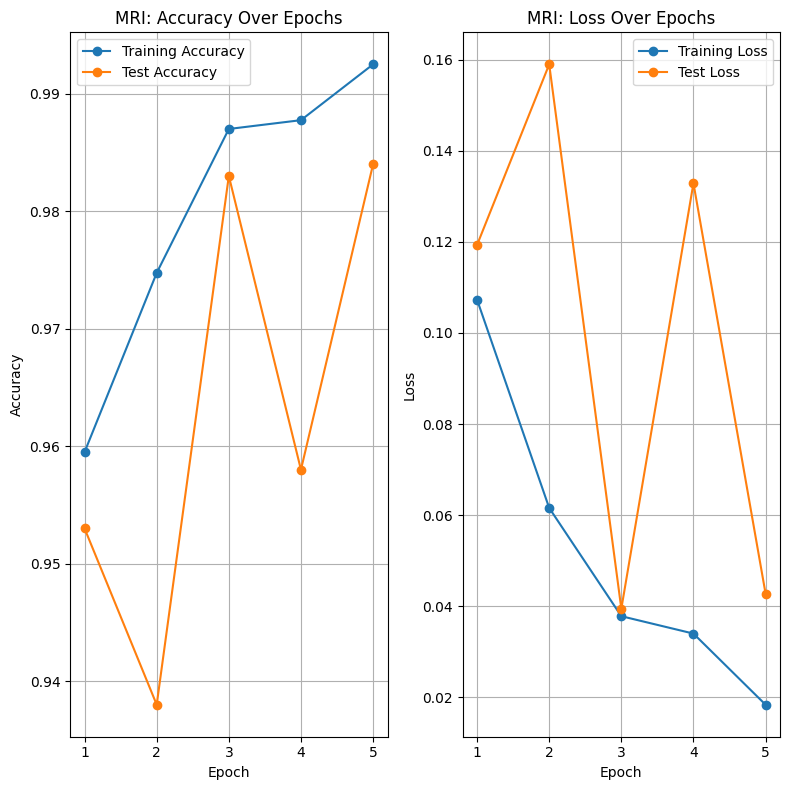

In [ ]:
# Accuracy
mobnet_model_accuracy = model_history_MRI.history['categorical_accuracy']
mobnet_model_val_accuracy = model_history_MRI.history['val_categorical_accuracy']
mobnet_model_loss = model_history_MRI.history['loss']
mobnet_model_val_loss = model_history_MRI.history['val_loss']
epochs = range(1, len(mobnet_model_accuracy) + 1)

plt.figure(figsize=(8,8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, mobnet_model_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, mobnet_model_val_accuracy, label='Test Accuracy', marker='o')
plt.title('MRI: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, mobnet_model_loss, label='Training Loss', marker='o')
plt.plot(epochs, mobnet_model_val_loss, label='Test Loss', marker='o')
plt.title('MRI: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Model Accuracy: 98.40%


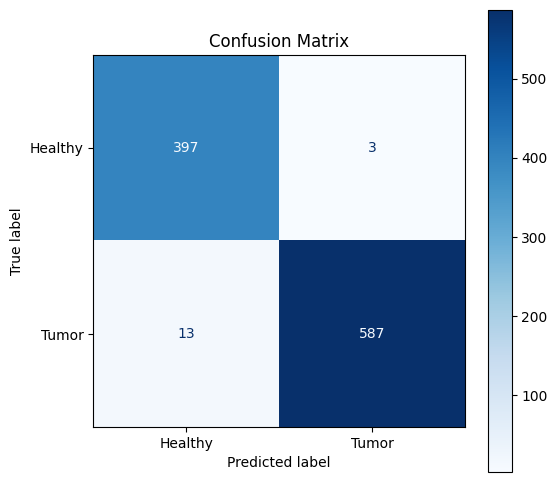

In [ ]:
# Extracting prediction and true lables

# Get predictions from the model
pred_base = mobnet_model.predict(test_MRI, verbose=0)
# Get predicted class indices
predicted_labels = np.argmax(pred_base, axis=1)

# Get true labels from the generator
true_labels = test_MRI.classes

# Print overall accuracy
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm_base = confusion_matrix(true_labels, predicted_labels)

# Display & save confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base,
                              display_labels=list(test_MRI.class_indices.keys()))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", bbox_inches='tight')
plt.show()

In [ ]:
# Compile the model
mobnet_model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Train the model for CT
model_history_CT = mobnet_model.fit(training_CT,epochs=5, batch_size=100, shuffle=True, validation_data=test_CT)

Epoch 1/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 185s 771ms/step - categorical_accuracy: 0.9529 - loss: 0.1420 - val_categorical_accuracy: 0.9307 - val_loss: 0.1897
Epoch 2/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 182s 788ms/step - categorical_accuracy: 0.9657 - loss: 0.1098 - val_categorical_accuracy: 0.9231 - val_loss: 0.2757
Epoch 3/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 182s 787ms/step - categorical_accuracy: 0.9680 - loss: 0.0894 - val_categorical_accuracy: 0.9458 - val_loss: 0.1521
Epoch 4/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 197s 764ms/step - categorical_accuracy: 0.9720 - loss: 0.0848 - val_categorical_accuracy: 0.9502 - val_loss: 0.1584
Epoch 5/5
231/231 ━━━━━━━━━━━━━━━━━━━━ 176s 763ms/step - categorical_accuracy: 0.9783 - loss: 0.0632 - val_categorical_accuracy: 0.9437 - val_loss: 0.2050


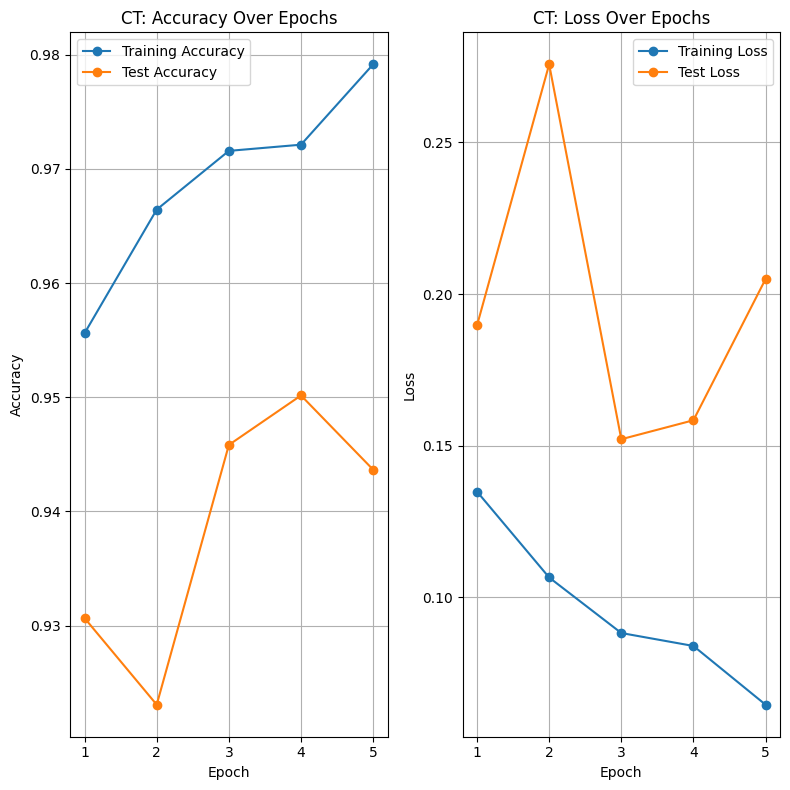

In [ ]:
# Accuracy
mobnet_model_accuracy = model_history_CT.history['categorical_accuracy']
mobnet_model_val_accuracy = model_history_CT.history['val_categorical_accuracy']
mobnet_model_loss = model_history_CT.history['loss']
mobnet_model_val_loss = model_history_CT.history['val_loss']
epochs = range(1, len(mobnet_model_accuracy) + 1)

plt.figure(figsize=(8,8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, mobnet_model_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, mobnet_model_val_accuracy, label='Test Accuracy', marker='o')
plt.title('CT: Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, mobnet_model_loss, label='Training Loss', marker='o')
plt.plot(epochs, mobnet_model_val_loss, label='Test Loss', marker='o')
plt.title('CT: Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Model Accuracy: 94.37%


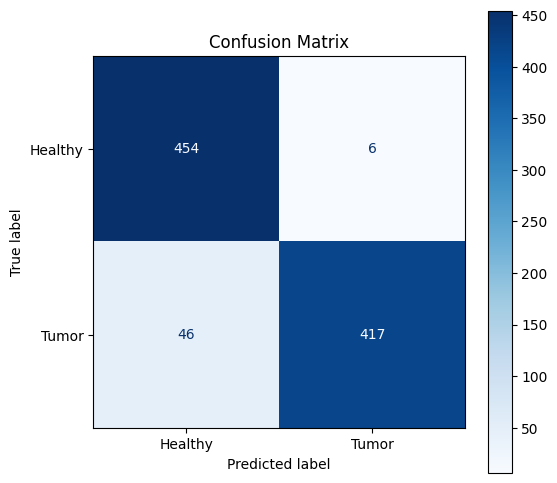

In [ ]:
# Get predictions from the model
pred_base = mobnet_model.predict(test_CT, verbose=0)

# Get true labels from the generator
true_labels = test_CT.classes

# Get predicted class indices
predicted_labels = np.argmax(pred_base, axis=1)

# Print overall accuracy
accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm_base = confusion_matrix(true_labels, predicted_labels)

# Display & save confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base,
                              display_labels=list(test_CT.class_indices.keys()))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", bbox_inches='tight')
plt.show()